<a href="https://colab.research.google.com/gist/EdwynZN/8ee4843a8d1880d35637d9bc4f046371/ds_c6_sc1_edwin_zambrano_nemegyei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
import math
import matplotlib.pyplot as plt
from sklearn import cluster, metrics, preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from google.colab import drive
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV

In [2]:
drive.mount('/content/gdrive');

Mounted at /content/gdrive


### Información de hoteles

In [3]:
hotel = pd.read_csv(r"/content/gdrive/My Drive/Colab Notebooks/data/DS_C6_SC1/hotel.csv")

In [ ]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

1.   Se eliminan datos donde los paises y niños son nulos (1%)
2.   Arrival y Reservation se convierten a dias desde unix timestamp
*reservation_status_date_year* por una columna con su año, mes y dia como las columnas del momento en el que llega (*arrival_date_year/month/day*)
3.   se elimina la columna *company* debido a que tiene una gran cantidad de nulos (95% nulos) y no aporta mucha información
4.   Se reemplaza los NaN de agent por la mediana
5.   Se convierten los meses a un valor númerico ordenados por Ene-Dec
6.   Se convierten con OneHotEncoder variables categoricas no ordenadas de menos de 12 valores y con Label aquellos que tengan más de 12

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ordinalEncoder = preprocessing.OrdinalEncoder().set_output(transform='pandas')
oneHotEncoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

hotel.dropna(subset=['country', 'children'], inplace=True)
hotel.drop('company', axis =1, inplace = True)
hotel['agent'] = hotel['agent'].fillna(value=hotel.agent.median())
hotel[['reservation_status_date_year', 'reservation_status_date_month', 'reservation_status_day_of_month']] = hotel.reservation_status_date.str.split('-', expand=True).astype(int)
hotel['arrival_date_month'] = pd.to_datetime(hotel['arrival_date_month'], format='%B').dt.month
#hotel['reservation_days_since_epoch'] = (pd.to_datetime(hotel.reservation_status_date, format="%Y-%m-%d") - datetime(1970,1,1)).dt.days
#hotel['arrival_days_since_epoch'] = (pd.to_datetime(hotel['arrival_date_year'].astype(str) + hotel['arrival_date_month'] + hotel['arrival_date_day_of_month'].astype(str), format='%Y%B%d') - datetime(1970,1,1)).dt.days
#pd.to_datetime(hotel['arrival_date_month'], format='%B').dt.month

hotel.drop(columns=[
  'reservation_status_date',
  #'arrival_date_year',
  #'arrival_date_day_of_month',
  #'arrival_date_month'
], inplace=True)

numerical_features = [
    "lead_time",
    #"arrival_days_since_epoch",
    "arrival_date_week_number",
    "arrival_date_year",
    "arrival_date_month",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "agent",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests",
    'reservation_status_date_year',
    'reservation_status_date_month',
    'reservation_status_day_of_month',
    #"reservation_days_since_epoch"
]
categorical_features = [
    "hotel",
    "country",
    "meal",
    "market_segment",
    "distribution_channel",
    "reserved_room_type",
    "assigned_room_type",
    "deposit_type",
    "customer_type",
    "reservation_status"
]
target = "is_canceled"

nunique_cat = hotel[categorical_features].nunique()
ordinal = ordinalEncoder.fit_transform(hotel[nunique_cat[nunique_cat > 12].index]).astype(int)
dummies = oneHotEncoder.fit_transform(hotel[nunique_cat[nunique_cat <= 12].index]).astype(int)

# transformed hotel df
tHotel = pd.concat([dummies, ordinal, hotel.loc[:, numerical_features + [target]]], axis=1)
pd.options.display.max_columns = None
tHotel.head()

,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reservation_status_Check-Out,reservation_status_No-Show,country,lead_time,arrival_date_week_number,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_day_of_month,is_canceled
0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,135,342,27,2015,7,1,0,0,2,0.0,0,0,0,0,3,14.0,0,0.0,0,0,2015,7,1,0
1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,135,737,27,2015,7,1,0,0,2,0.0,0,0,0,0,4,14.0,0,0.0,0,0,2015,7,1,0
2,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,59,7,27,2015,7,1,0,1,1,0.0,0,0,0,0,0,14.0,0,75.0,0,0,2015,7,2,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,59,13,27,2015,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.0,0,0,2015,7,2,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,59,14,27,2015,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1,2015,7,3,0


- Eliminamos Reservation_Status_Check_out pues todos aquellos que hicieron check out son las personas que no cancelaron y explican la variable independiente de manera exacta (check out = no cancelo)


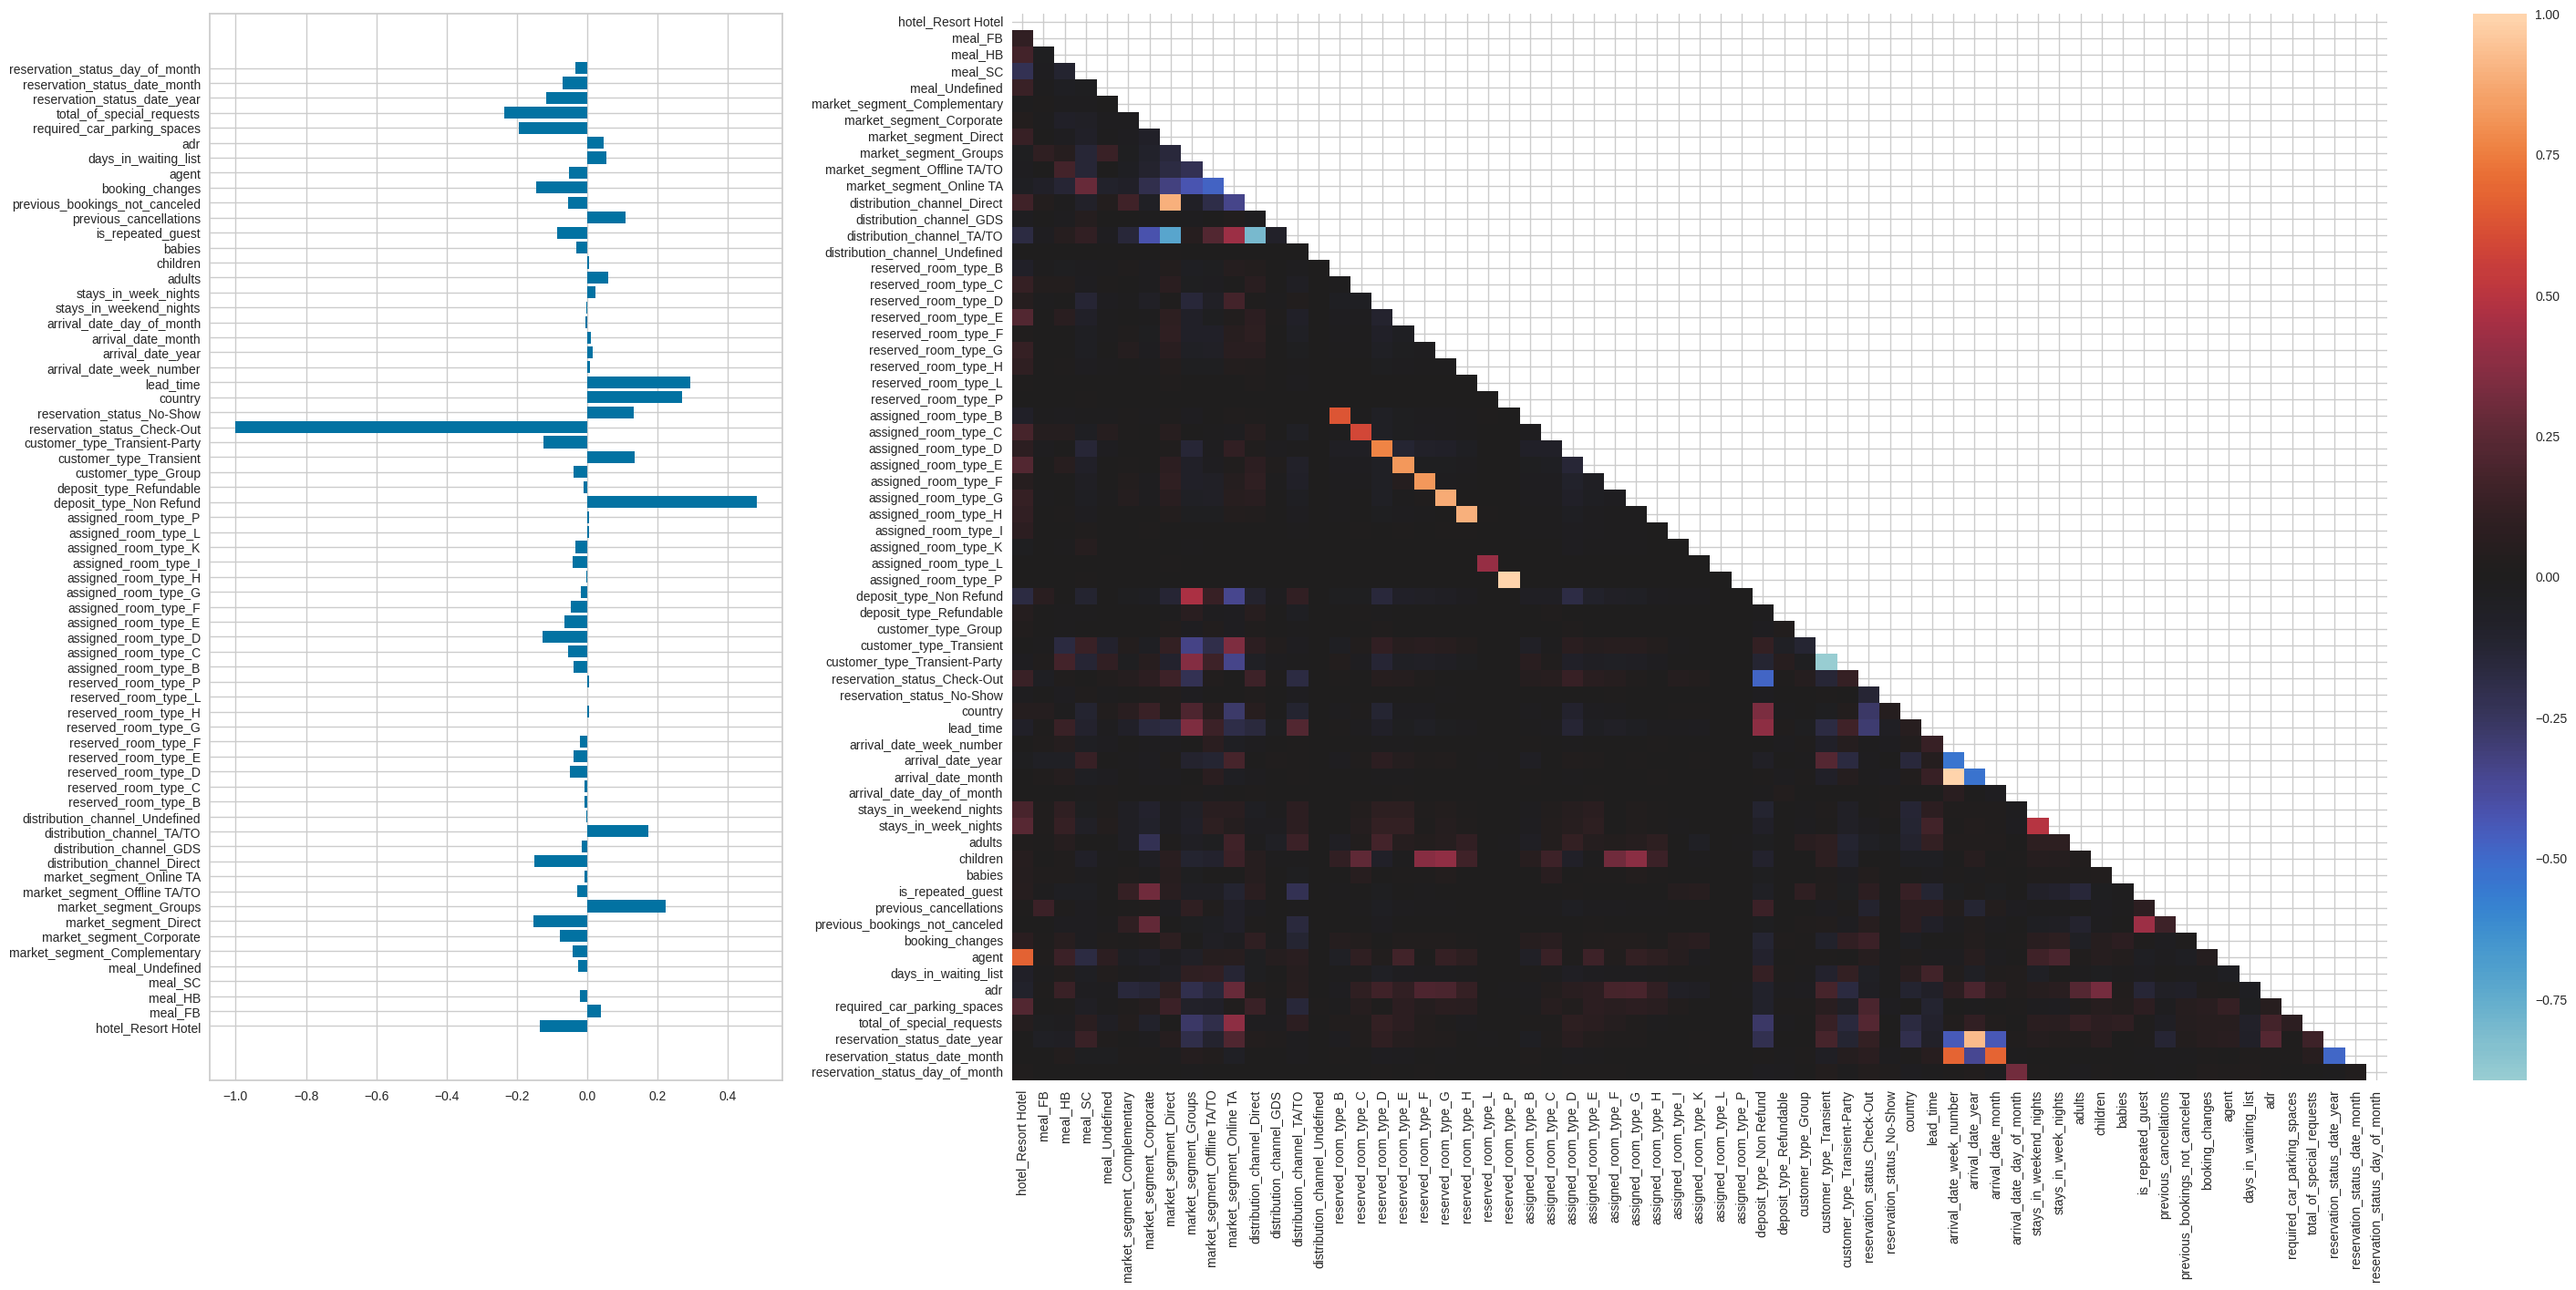

In [5]:
from yellowbrick.target import FeatureCorrelation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35.68, 15.20), gridspec_kw={'width_ratios': [1, 3]})

features = tHotel.loc[:, tHotel.columns != target]
visualizer = FeatureCorrelation(ax= ax1, labels=features.columns)
visualizer.fit(features, tHotel[target])

corr = features.corr()
mask = np.triu(np.ones_like(features.corr(), dtype=bool))
sns.heatmap(corr, mask=mask, center=0, ax=ax2)

fig.show();
tHotel.drop('reservation_status_Check-Out', axis=1, inplace=True)

Existe una mayor proporción de reservaciones no canceladas (38% cancelados vs 62% no) por lo que se debe estratificar y balancer

In [6]:
tHotel['is_canceled'].value_counts()

0    74745
1    44153
Name: is_canceled, dtype: int64

### Funciones de visualización para reporte de clasificación

In [7]:
def rocVisual(estimator, x, y, ax = None):
  from yellowbrick.classifier import ROCAUC
  roc_curves_visualizer = ROCAUC(
      estimator,
      ax,
      classes=[0, 1],
      is_fitted=True,
  )
  roc_curves_visualizer.fit(x, y);
  roc_curves_visualizer.score(x, y);
  roc_curves_visualizer.show();

In [8]:
def precRecVisual(estimator, x, y, ax = None):
  from yellowbrick.classifier import PrecisionRecallCurve
  precision_rec_visualizer = PrecisionRecallCurve(
      estimator,
      ax,
      classes=[0, 1],
      is_fitted=True,
  )
  precision_rec_visualizer.fit(x, y);
  precision_rec_visualizer.score(x, y);
  precision_rec_visualizer.show();

In [9]:
def report(model):
  import functools
  from sklearn.metrics import classification_report
  from yellowbrick.classifier import ClassificationReport
  fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2]})

  y_pred = model.predict(x_valid)
  cm = confusion_matrix(y_valid, y_pred)

  cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)

  print(f'neg_mean_squared_error: {model.score(x_valid, y_valid)}')
  print(f'accuracy: {(cm_display.confusion_matrix[0][0] + cm_display.confusion_matrix[1][1]) / functools.reduce(lambda a, b: a+b, cm_display.confusion_matrix.flatten())}')

  visualizer = ClassificationReport(model, support=True, classes=model.classes_, is_fitted=True, ax=ax2);
  visualizer.class_counts_ = 2
  visualizer.score(x_valid, y_valid);
  visualizer.show();

  rocVisual(model, x_valid, y_valid)
  precRecVisual(model, x_valid, y_valid)

### Construir un conjunto de entrenamiento y prueba

Se cosntruye el conjunto de entrenamiento, validacion y prueba. La validación se usara para comparar modelos y el de prueba al final al escoger el mejor modelo y dar el resultado final

In [12]:
scaler = preprocessing.MinMaxScaler().set_output(transform='pandas')
#X = hotel.loc[:, hotel.columns != 'is_canceled']
#y = hotel['is_canceled']

### Data is stratified by the output (is_canceled)
### Training data - 70%
### Valid data - 15%
### Test data - 15%
train, redux = train_test_split(tHotel, test_size=0.3, stratify=tHotel[target], random_state=42)
valid, test = train_test_split(redux, test_size=0.5, stratify=redux[[target]], random_state=42)

scalerFeatures = numerical_features
scaler.fit(train[scalerFeatures])
test[scalerFeatures] = scaler.transform(test[scalerFeatures])
train[scalerFeatures] = scaler.transform(train[scalerFeatures])
valid[scalerFeatures] = scaler.transform(valid[scalerFeatures])

In [13]:
x_test = test.loc[:, test.columns != target].to_numpy()
x_train = train.loc[:, train.columns != target].to_numpy()
x_valid = valid.loc[:, valid.columns != target].to_numpy()

y_test = test[target].to_numpy()
y_train = train[target].to_numpy()
y_valid = valid[target].to_numpy()

In [ ]:
base_model = LogisticRegressionCV(
    Cs = [1e-5, 7e-4, 1e-3],
    penalty = "l1",
    solver = "saga",
    max_iter = 500,
    cv = 10,
    random_state=42,
    scoring = 'neg_root_mean_squared_error',
    class_weight = 'balanced',
    n_jobs=-1,
)
base_model.fit(x_train, y_train)

LogisticRegressionCV(Cs=[1e-05, 0.0007, 0.001], class_weight='balanced', cv=10,
                     max_iter=500, n_jobs=-1, penalty='l1', random_state=42,
                     scoring='neg_root_mean_squared_error', solver='saga')

neg_mean_squared_error: -0.5339602427059343
accuracy: 0.7148864592094197


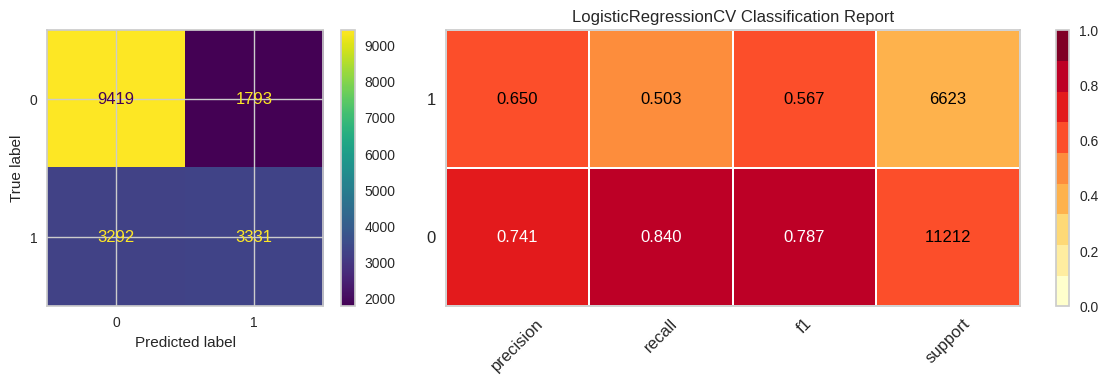

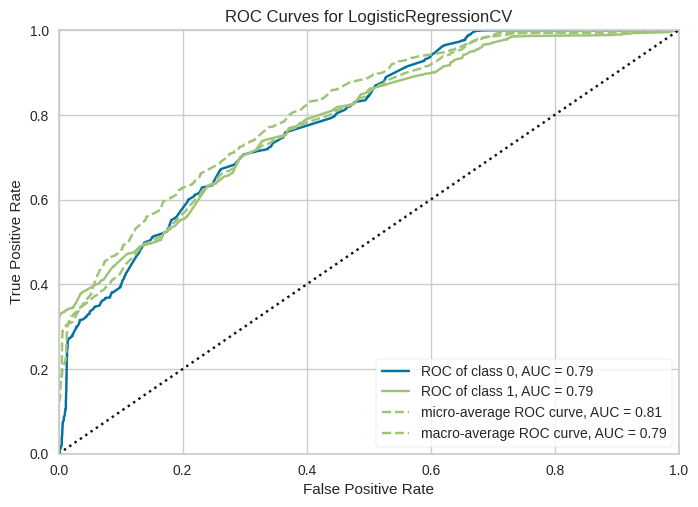

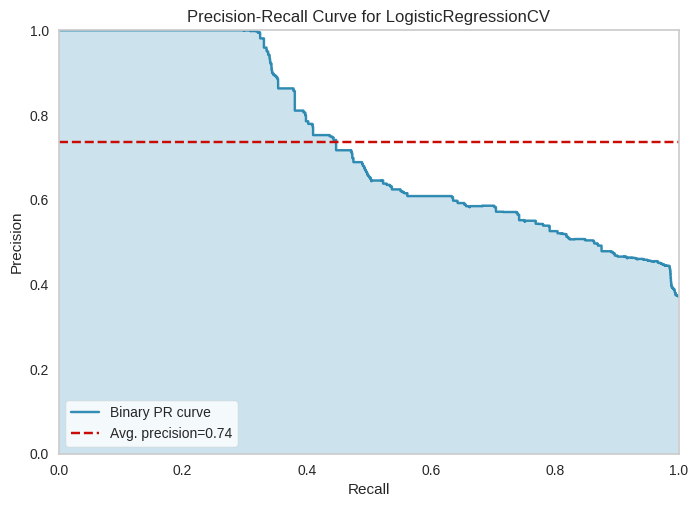

In [ ]:
report(base_model)

Existen muchos falsos negativos (casi tantos como verdarderos positivos) por lo que el recall esta en la mitad y el F1 de la clasisficación de cancelaciones tambien se encuentra en un punto medio.

El sistema es mejor detectando cuando no existen cancelaciones, quizas por el desbalanceo de las clases en su entrenamiento por lo que es necesario ajustar las variables e hiperparametros para mejorar el recall y F1 en la clase de cancelaciones.

### Búsqueda de un mejor modelo

In [10]:
# Filtrar variables con mucha correlación entre las independientes y pocas con la dependiente
def preproccessCorr(data: pd.DataFrame, targetName: str, lvs = 0.1, lev = 0.9) -> pd.DataFrame:
  corr = data.corr()
  #corr[:] = np.tril(corr.values, k=-1)

  y_1 = corr.loc[targetName, :]
  #y_2 = corr.loc['Attrition_Yes', :]

  setValue = set(y_1.loc[y_1.abs() > lvs].index.to_list())

  removed = set([])
  xlist = list(setValue)
  for i in range(len(xlist)):
      value = xlist[i]
      for j in range(i, len(xlist)):
          comparator = xlist[j]
          if (comparator == value or j <= i):
              continue
          correlation = abs(corr.at[value, comparator])
          if (correlation >= lev):
              removed.add(value) if (abs(corr.at[targetName, comparator]) > abs(corr.at[targetName, value])) else removed.add(comparator)

  setValue.difference_update(removed)
  selected = list(setValue)
  correlated_map = corr.loc[selected, selected]

  correlated_map[:] = np.tril(correlated_map.values, k=-1)
  return correlated_map

Se buscan las variables independientes con mayor correlacion entre si y se eliminan, dejando solo la que mayor correlación tiene con la dependiente, de igual manera se eliminan las que tienen menor correlación con la dependiente

In [14]:
corr = preproccessCorr(tHotel, target, 0.05, 0.95);
newFeatures = corr.loc[:, corr.columns != target]

df_x_test = test.loc[:, newFeatures.columns]
df_x_train = train.loc[:, newFeatures.columns]
df_x_valid = valid.loc[:, newFeatures.columns]

x_test = df_x_test.to_numpy()
x_train = df_x_train.to_numpy()
x_valid = df_x_valid.to_numpy()

newFeatures.columns.to_list()

['previous_cancellations',
 'adults',
 'lead_time',
 'market_segment_Corporate',
 'agent',
 'assigned_room_type_E',
 'booking_changes',
 'assigned_room_type_D',
 'market_segment_Groups',
 'market_segment_Direct',
 'customer_type_Transient-Party',
 'customer_type_Transient',
 'hotel_Resort Hotel',
 'deposit_type_Non Refund',
 'reservation_status_No-Show',
 'previous_bookings_not_canceled',
 'distribution_channel_Direct',
 'reservation_status_date_month',
 'days_in_waiting_list',
 'country',
 'distribution_channel_TA/TO',
 'reservation_status_date_year',
 'assigned_room_type_C',
 'required_car_parking_spaces',
 'is_repeated_guest',
 'total_of_special_requests']

In [15]:
better_model = LogisticRegression(
    penalty = "l1",
    max_iter = 300,
    random_state=42,
    class_weight = 'balanced',
)

In [16]:
gridCV = GridSearchCV(
    better_model,
    {
      'solver': ['liblinear', 'saga'],
      'C' : np.arange(1e-3, 1.1e-1, 2.5e-2),
    },
    return_train_score=True,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=10
)

gridCV.fit(x_train, y_train)
y_pred = gridCV.predict(x_valid)

In [16]:
# Para evitar correr de nuevo el grid search
best_model = LogisticRegressionCV(
    penalty = "l1",
    Cs = [0.101],
    solver='liblinear',
    max_iter = 300,
    random_state=42,
    class_weight = 'balanced',
    cv=10
)
best_model.fit(x_train, y_train)

LogisticRegressionCV(Cs=[0.101], class_weight='balanced', cv=10, max_iter=300,
                     penalty='l1', random_state=42, solver='liblinear')

In [17]:
def fun_plot_grid_search_results(df):
  cm = sns.diverging_palette(5, 250, as_cmap=True)
  return (
    pd.concat([
        df['params'].apply(pd.Series),
        df[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
        axis = 1
    )\
    .sort_values(by = 'rank_test_score')\
    .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
  )

In [18]:
fun_plot_grid_search_results(pd.DataFrame(gridCV.cv_results_))

,C,solver,mean_train_score,mean_test_score,rank_test_score
8,0.101000,liblinear,-0.471914,-0.471947,1
6,0.076000,liblinear,-0.473652,-0.473679,2
4,0.051000,liblinear,-0.475922,-0.476096,3
2,0.026000,liblinear,-0.477200,-0.477437,4
9,0.101000,saga,-0.478898,-0.479033,5
7,0.076000,saga,-0.479027,-0.479148,6
5,0.051000,saga,-0.479234,-0.479285,7
3,0.026000,saga,-0.479455,-0.479518,8
0,0.001000,liblinear,-0.532015,-0.532238,9
1,0.001000,saga,-0.536124,-0.536204,10


neg_mean_squared_error: 0.7807120829828988
accuracy: 0.7807120829828988


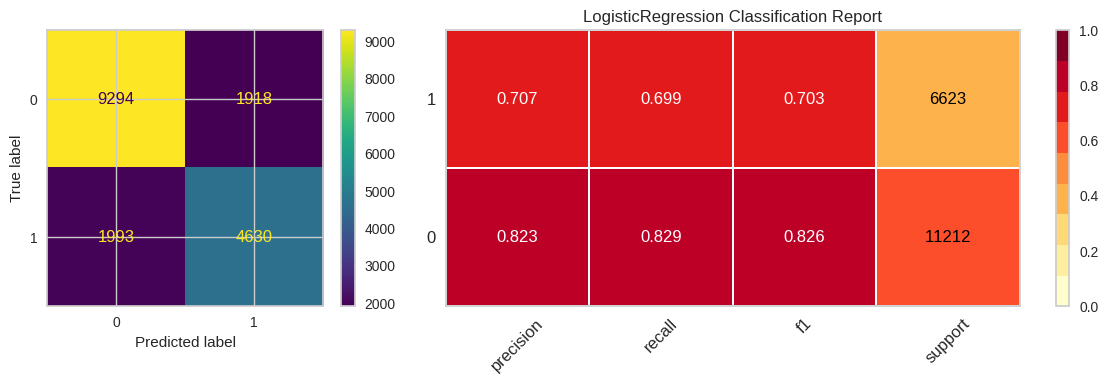

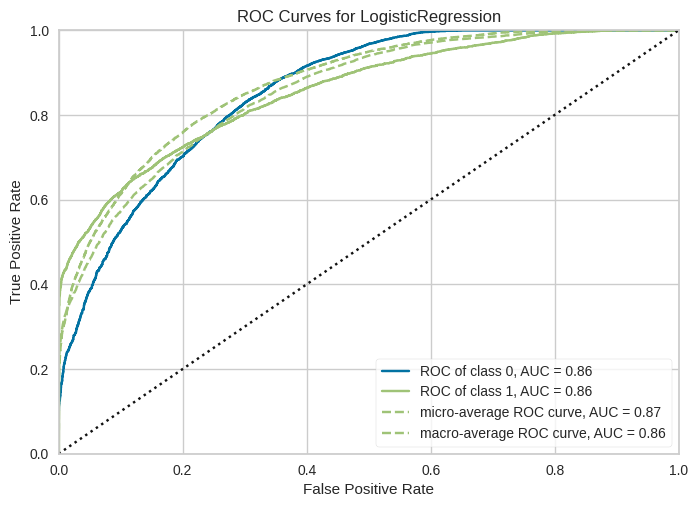

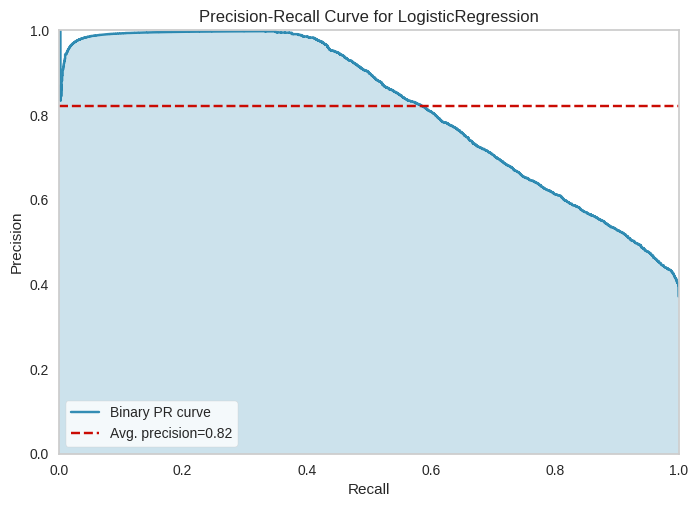

In [19]:
best_model = gridCV.best_estimator_
report(best_model)

El cambio de threshold es minimo (0.01) pero se asume para una ultima prueba

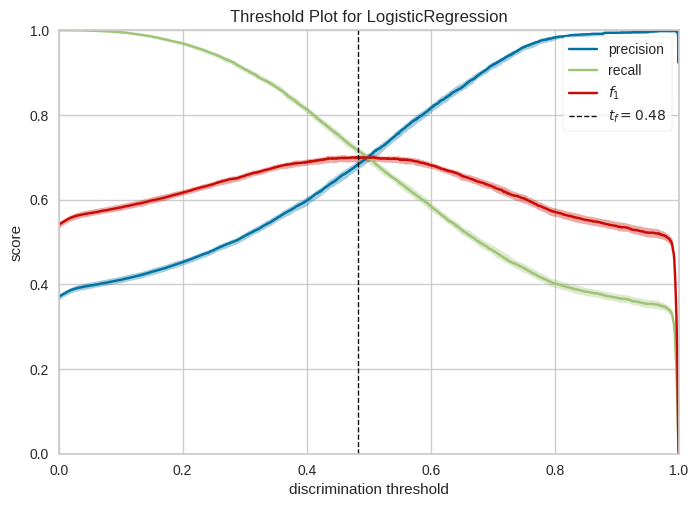

In [20]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(best_model, is_fitted=True, exclude=['queue_rate'])
visualizer.fit(x_train, y_train)
visualizer.show();

original
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     11212
           1       0.71      0.70      0.70      6623

    accuracy                           0.78     17835
   macro avg       0.77      0.76      0.76     17835
weighted avg       0.78      0.78      0.78     17835

----with threshold----
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     11212
           1       0.70      0.71      0.70      6623

    accuracy                           0.78     17835
   macro avg       0.76      0.76      0.76     17835
weighted avg       0.78      0.78      0.78     17835



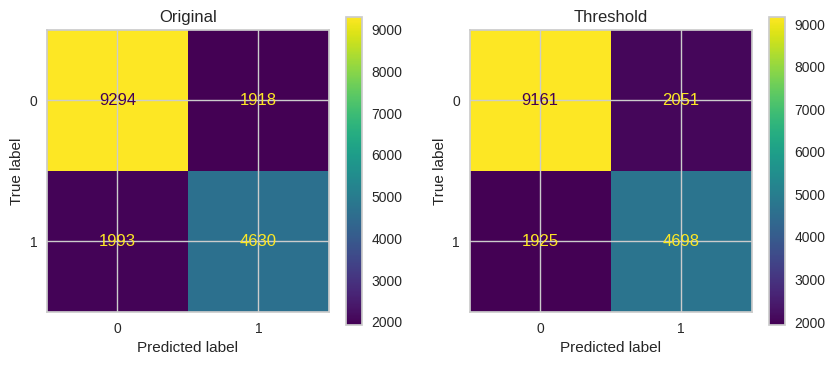

In [23]:
import functools
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report
threshold = 0.49

y_pred = best_model.predict(x_valid)
y_prob = np.where(best_model.predict_proba(x_valid)[:, 1] < threshold, 0, 1)

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
cm = confusion_matrix(y_valid, y_pred)
ax1.set_title('Original')

cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)

cm2 = confusion_matrix(y_valid, y_prob)
cm_display2 = ConfusionMatrixDisplay(cm2).plot(ax=ax2)
ax2.set_title('Threshold')
fig.show()

target_names = ['0', '1']
print('original')
print(classification_report(y_valid, y_pred, target_names=target_names))
print('----with threshold----')
print(classification_report(y_valid, y_prob, target_names=target_names))

El resultado con el nuevo threshold mejora para las cancelaciones pero empeora para los no cancelados, como se intenta acercar más a investigar las cancelaciones este nuevo modelo puede ser más útil. Se realiza una última prueba usando este nuevo modelo y los datos de test en vez de validacion (los datos de test no se usaron en nigun momento del experimento)

### Resultado con el conjunto de test final

original
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     11212
           1       0.71      0.70      0.71      6623

    accuracy                           0.78     17835
   macro avg       0.77      0.77      0.77     17835
weighted avg       0.78      0.78      0.78     17835

----with threshold----
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     11212
           1       0.70      0.71      0.71      6623

    accuracy                           0.78     17835
   macro avg       0.76      0.77      0.76     17835
weighted avg       0.78      0.78      0.78     17835



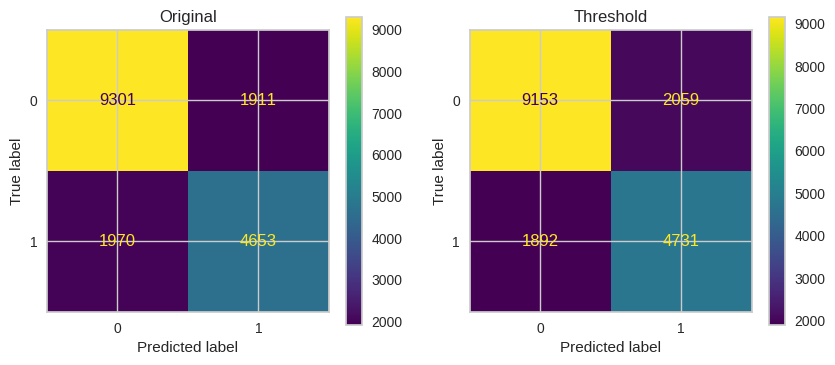

In [52]:
y_pred = best_model.predict(x_test)
y_prob = np.where(best_model.predict_proba(x_test)[:, 1] < threshold, 0, 1)

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Original')

cm2 = confusion_matrix(y_test, y_prob)
cm_display2 = ConfusionMatrixDisplay(cm2).plot(ax=ax2)
ax2.set_title('Threshold')
fig.show()

target_names = ['0', '1']
print('original')
print(classification_report(y_test, y_pred, target_names=target_names))
print('----with threshold----')
print(classification_report(y_test, y_prob, target_names=target_names))

### Generar un CSV con todos los datos de reservaciones que incluya: id de la reservación, la probabilidad de cancelación y la clasificación de cancelación

In [21]:
X = pd.concat([df_x_train, df_x_valid, df_x_test], axis=0)
ids = X.index.to_frame(index=False, name= 'id')

In [24]:
prob = best_model.predict_proba(X.to_numpy())
classification = np.where(prob[:, 1] < threshold, 0, 1)

result = pd.DataFrame({'probabilidad': pd.Series(prob[:, 1]), 'class': pd.Series(classification)})
result = pd.concat([ids, result], axis=1)

result.sort_values(by=['id']).to_csv(path_or_buf= 'sample_data/result.csv', index=False);